In [11]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from resources import load_data, custom_k_fold_split
from tqdm import tqdm

def fit_and_evaluate_model(model, X, y):
    accuracy, precision, recall = [], [], []
    for fold in custom_k_fold_split(X, y, method='individual'):
        X_train, X_test, y_train, y_test = fold
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        accuracy.append(accuracy_score(y_test, predictions))
        precision.append(precision_score(y_test, predictions, average='weighted', zero_division=0))
        recall.append(recall_score(y_test, predictions, average='weighted'      , zero_division=0))
    return accuracy, precision, recall

def custom_resample(num_iterations, n_samples):
    sets = []
    for i in range(num_iterations):
        df = pd.read_csv('data/HR_data.csv', index_col=0)
        df.sample(n_samples, replace=True).reset_index().to_csv('data/HR_data_bootstrapped.csv')
        X, y = load_data('data/HR_data_bootstrapped.csv')
        sets.append((X, y))
    return sets

def no_resample():
    X, y = load_data('data/HR_data.csv')
    return [(X, y)]

def bootstrap_evaluation(model, sets):
    bootstrap_results = {
        'accuracy': [],
        'precision':[],
        'recall': []
    }

    for X, y in tqdm(sets, desc=str(model).split('.')[-1].split("\'")[0]):
        model_ = model()
        accuracy, precision, recall = fit_and_evaluate_model(model_, X, y)
        bootstrap_results['accuracy'].append(accuracy)
        bootstrap_results['precision'].append(precision)
        bootstrap_results['recall'].append(recall)

    list_of_metrics = [[],[],[]]
    for i, metric in enumerate(bootstrap_results.keys()):            
        for round in bootstrap_results[metric]:
            for val in round:
                list_of_metrics[i].append(val)
    # returns accuracy, precision, recall
    return list_of_metrics

MLPClassifier: 100%|██████████| 5/5 [00:05<00:00,  1.18s/it]


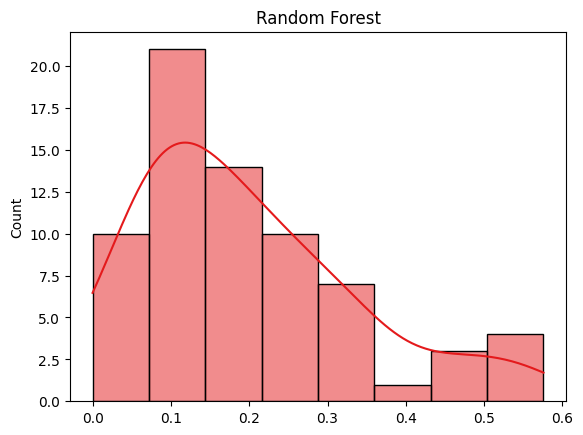

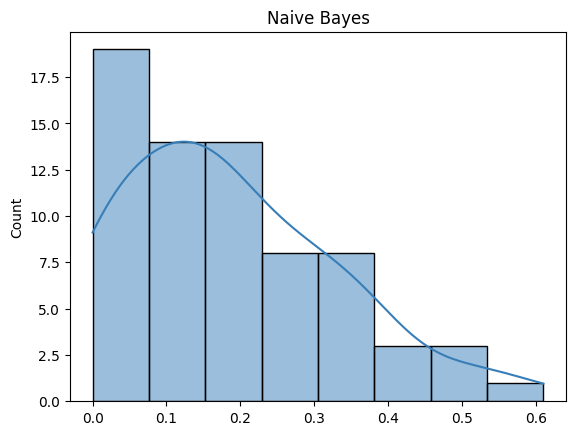

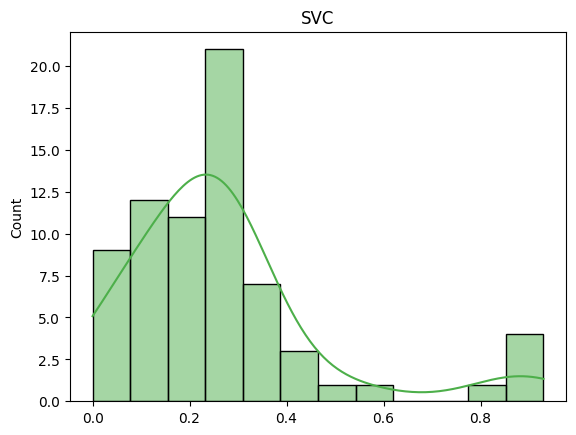

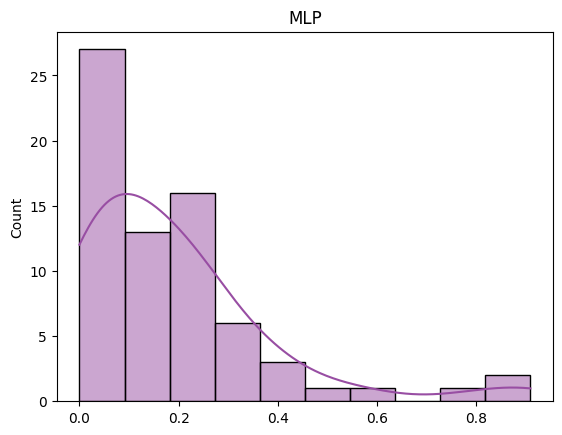

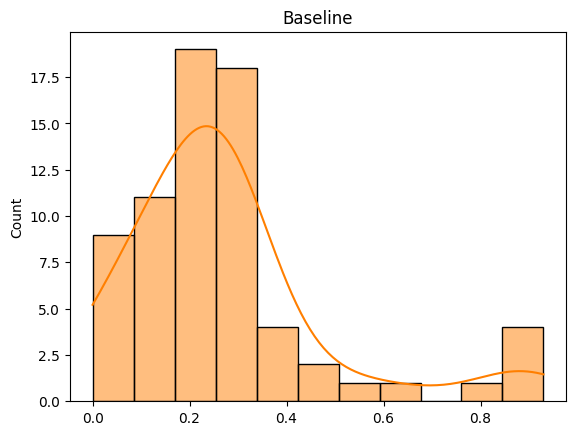

Random Forest Naive Bayes SVC MLP Baseline
0.1974747279640533 0.18660313439849915 0.2646741660924106 0.18827041363419053 0.2714796396064179
0.2637568544676777 0.22539650582707138 0.11848770087939474 0.08411197469514521 0.11730254573011363
0.1974747279640533 0.18660313439849915 0.2646741660924106 0.18827041363419053 0.2714796396064179


In [13]:
from models import Baseline
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

data = custom_resample(5, 1000)

acc, precision, recall = bootstrap_evaluation(RandomForestClassifier, data)
base_acc, base_precision, base_recall = bootstrap_evaluation(Baseline, data)
nb_acc, nb_precision, nb_recall = bootstrap_evaluation(GaussianNB, data)
svc_acc, svc_precision, svc_recall = bootstrap_evaluation(SVC, data)
nn_acc, nn_precision, nn_recall = bootstrap_evaluation(MLPClassifier, data)
models = ['Random Forest', 'Naive Bayes', 'SVC', 'MLP','Baseline']
accuracies = [acc, nb_acc, svc_acc, nn_acc, base_acc]

import seaborn as sns
import matplotlib.pyplot as plt

colors = sns.color_palette('Set1', n_colors=5)
for model, accuracy, color in zip(models, accuracies, colors):
    sns.histplot(accuracy, color=color, kde=True, label=model)
    plt.title(f'{model} Accuracy Distribution')
    plt.savefig(f'plots/{model}_accuracy_dist.png')
    plt.show()

print('Random Forest', 'Naive Bayes', 'SVC', 'MLP','Baseline')
print(np.mean(acc), np.mean(nb_acc), np.mean(svc_acc), np.mean(nn_acc), np.mean(base_acc))
print(np.mean(precision), np.mean(nb_precision), np.mean(svc_precision), np.mean(nn_precision), np.mean(base_precision))
print(np.mean(recall), np.mean(nb_recall), np.mean(svc_recall), np.mean(nn_recall), np.mean(base_recall))

import pickle
for model, accuracies in zip(models, [acc, nb_acc, svc_acc, nn_acc, base_acc]):
    with open(f'metrics/{model}.pkl', 'wb') as f:
        pickle.dump(accuracies, f)

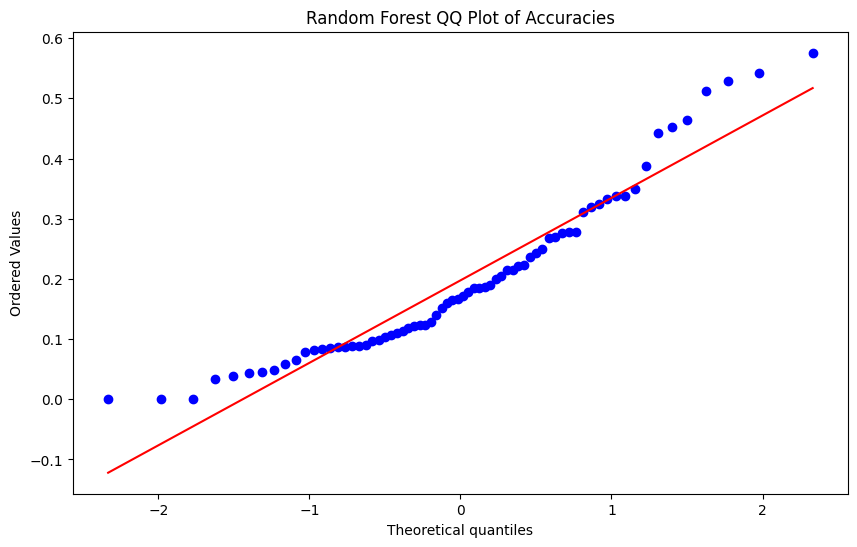

Shapiro-Wilk Test Statistic: 0.9209037705350547
Shapiro-Wilk Test p-value: 0.00028874346128984464
The data is not normally distributed (reject H0)


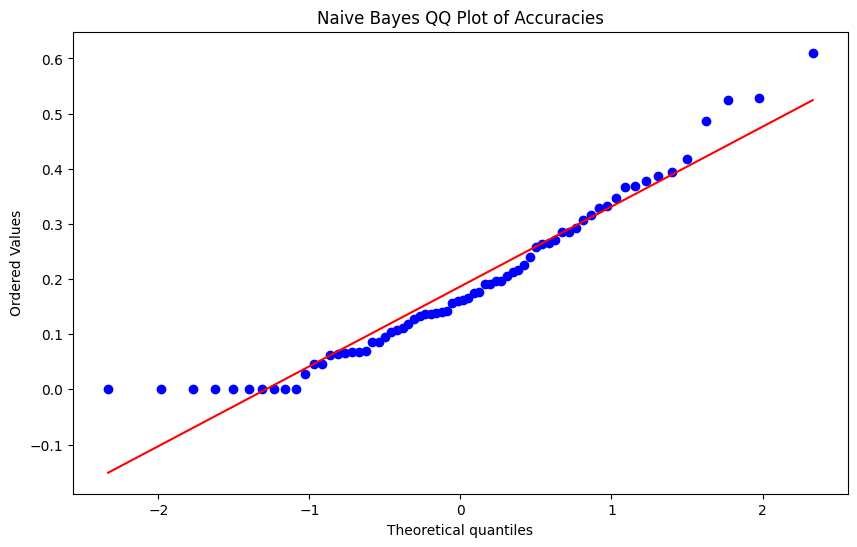

Shapiro-Wilk Test Statistic: 0.9394612675932041
Shapiro-Wilk Test p-value: 0.002114738975004644
The data is not normally distributed (reject H0)


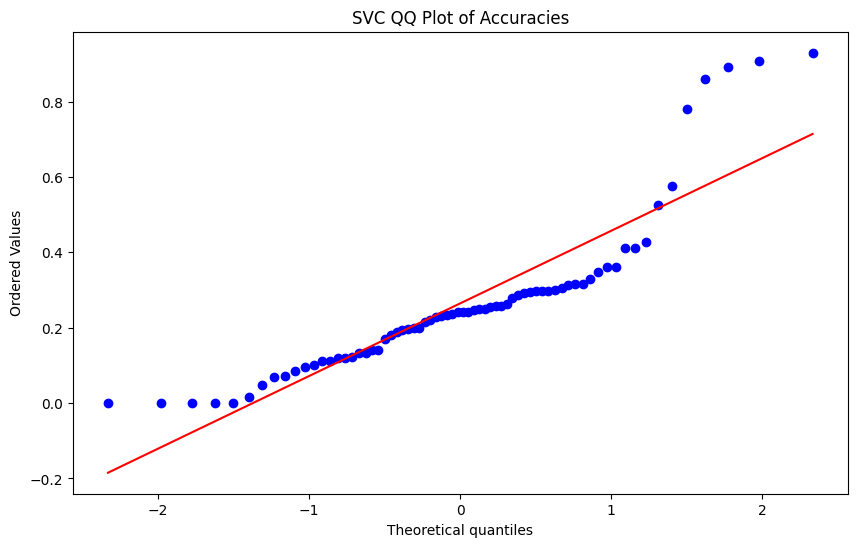

Shapiro-Wilk Test Statistic: 0.8217166033308343
Shapiro-Wilk Test p-value: 9.477318992860343e-08
The data is not normally distributed (reject H0)


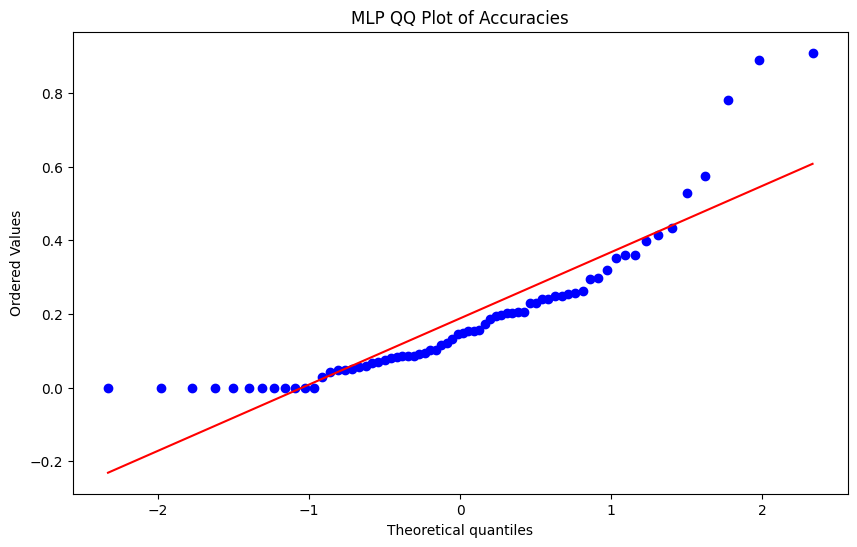

Shapiro-Wilk Test Statistic: 0.807937603149609
Shapiro-Wilk Test p-value: 3.910731478221859e-08
The data is not normally distributed (reject H0)


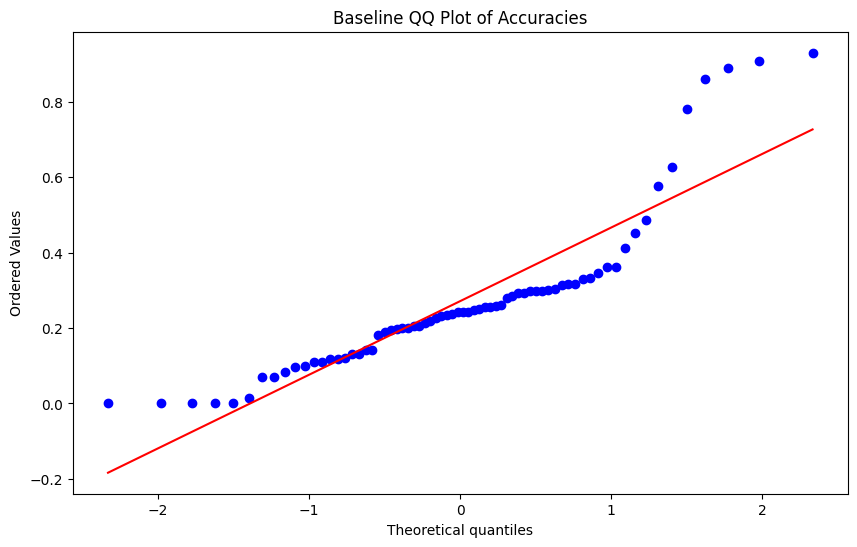

Shapiro-Wilk Test Statistic: 0.8271094758647013
Shapiro-Wilk Test p-value: 1.355441210827055e-07
The data is not normally distributed (reject H0)


In [21]:
from scipy import stats

for model, accuracies in zip(models, [acc, nb_acc, svc_acc, nn_acc, base_acc]):
    # QQ Plot
    plt.figure(figsize=(10, 6))
    stats.probplot(accuracies, dist="norm", plot=plt)
    plt.title(f"{model} QQ Plot of Accuracies")
    plt.show()

    # Shapiro-Wilk Test
    shapiro_test = stats.shapiro(accuracies)
    print("Shapiro-Wilk Test Statistic:", shapiro_test.statistic)
    print("Shapiro-Wilk Test p-value:", shapiro_test.pvalue)

    # Interpretation
    if shapiro_test.pvalue > 0.05:
        print("The data is normally distributed (fail to reject H0)")
    else:
        print("The data is not normally distributed (reject H0)")

In [22]:
from scipy.stats import kruskal

# Example accuracies from three models


# Kruskal-Wallis H Test
kruskal_test = kruskal(*[acc, nb_acc, svc_acc, nn_acc, base_acc])
print("Kruskal-Wallis H Test Statistic:", kruskal_test.statistic)
print("Kruskal-Wallis H Test p-value:", kruskal_test.pvalue)

# Interpretation
if kruskal_test.pvalue > 0.05:
    print("No significant difference between the models (fail to reject H0)")
else:
    print("Significant difference between the models (reject H0)")


Kruskal-Wallis H Test Statistic: 17.804498280670938
Kruskal-Wallis H Test p-value: 0.001347522950917675
Significant difference between the models (reject H0)


In [25]:
from scipy.stats import wilcoxon

p_val_matrix = np.zeros((5, 5))

for model, accuracies in zip(models, [acc, nb_acc, svc_acc, nn_acc, base_acc]):

    for model2, accuracies2 in zip(models, [acc, nb_acc, svc_acc, nn_acc, base_acc]):
        if model == model2:
            continue

        print(f"Comparing {model} and {model2}")

        # Wilcoxon Signed-Rank Test
        wilcoxon_test = wilcoxon(accuracies, accuracies2)
        print("Wilcoxon Test Statistic:", wilcoxon_test.statistic)
        print("Wilcoxon Test p-value:", wilcoxon_test.pvalue)

        # Interpretation
        if wilcoxon_test.pvalue > 0.05:
            print("No significant difference between the two models (fail to reject H0)")
        else:
            print("Significant difference between the two models (reject H0)")
        print('\n')
        p_val_matrix[models.index(model), models.index(model2)] = wilcoxon_test.pvalue


Comparing Random Forest and Naive Bayes
Wilcoxon Test Statistic: 1075.0
Wilcoxon Test p-value: 0.5492955650587227
No significant difference between the two models (fail to reject H0)


Comparing Random Forest and SVC
Wilcoxon Test Statistic: 845.5
Wilcoxon Test p-value: 0.06674385000024795
No significant difference between the two models (fail to reject H0)


Comparing Random Forest and MLP
Wilcoxon Test Statistic: 877.5
Wilcoxon Test p-value: 0.202549078570063
No significant difference between the two models (fail to reject H0)


Comparing Random Forest and Baseline
Wilcoxon Test Statistic: 752.0
Wilcoxon Test p-value: 0.02393330290714443
Significant difference between the two models (reject H0)


Comparing Naive Bayes and Random Forest
Wilcoxon Test Statistic: 1075.0
Wilcoxon Test p-value: 0.5492955650587227
No significant difference between the two models (fail to reject H0)


Comparing Naive Bayes and SVC
Wilcoxon Test Statistic: 899.5
Wilcoxon Test p-value: 0.06554364605082888
No 

c:\Users\pvest\anaconda3\envs\mldm\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: Sample size too small for normal approximation.
  res = hypotest_fun_out(*samples, **kwds)


c:\Users\pvest\anaconda3\envs\mldm\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: Sample size too small for normal approximation.
  res = hypotest_fun_out(*samples, **kwds)


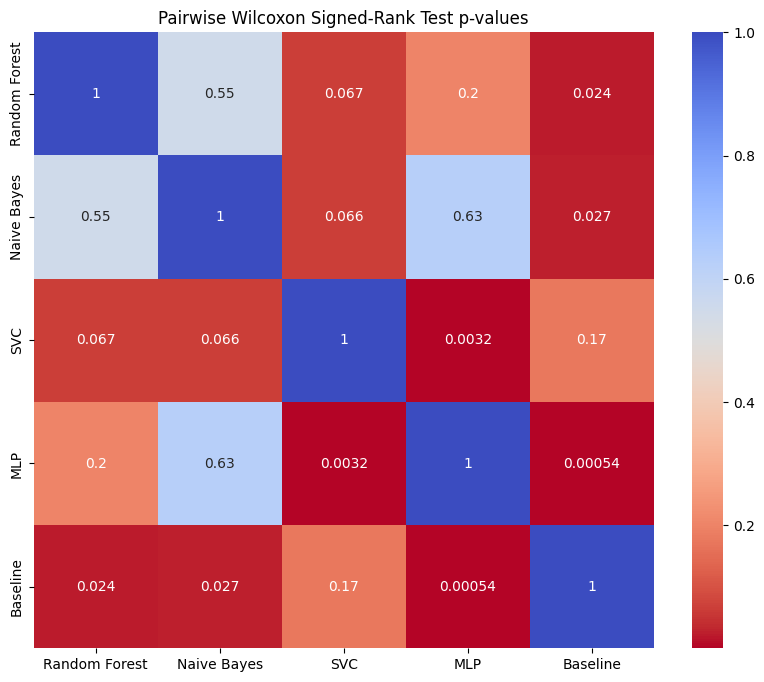

In [33]:
# List of accuracy lists
accuracies_list = [acc, nb_acc, svc_acc, nn_acc, base_acc]

# Initialize p-value matrix
p_val_matrix = np.ones((len(models), len(models))) 

# Compute pairwise Wilcoxon Signed-Rank Test
for i, accuracies in enumerate(accuracies_list):
    for j, accuracies2 in enumerate(accuracies_list):
        if i == j:
            continue
        wilcoxon_test = wilcoxon(accuracies, accuracies2)
        p_val_matrix[i, j] = wilcoxon_test.pvalue

# Visualize p-value matrix with heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(p_val_matrix, xticklabels=models, yticklabels=models, annot=True, cmap='coolwarm_r', cbar=True)
plt.title('Pairwise Wilcoxon Signed-Rank Test p-values')
plt.show()